# Heart Disease Prediction

## Introduction
Our data was collected by the Hungarian Institute of Cardiology in Budapest on Heart Disease patients.
Heart disease can refer to several types of heart conditions, the most common being the buildup of plaque in the major blood vessels leading to the heart. Cholesterol deposits in the arteries reduce blood flow to the heart. 
Our project aims to determine if someone has heart disease, based on some of the predictors in the dataset.
We will be using the Heart Disease data folder. Specifically,  we are using the Processed Hungarian Data, which is a data set in the Heart Disease folder.

## Preliminary Data Analysis and Methods
To conduct our data analysis, we will filter out the columns with mostly missing data, which are the slope of the peak exercise ST segment, number of major vessels coloured by fluoroscopy, and thal. Additionally, if there is a patient with a missing value in any other column, we will filter that specific patient out as well.  Doing so will ensure our results are consistent for each patient.  Therefore, we will use these columns: age, sex , chest pain type, resting blood pressure,  serum cholestorol levels,  fasting blood sugar, resting electrocardiographic results,maximum heart rate achieved, exercise induced angina, and ST depression induced by exercise relative to rest.
We can plot 2 relevant predictors such as age and max heart rate values onto a scatter plot using ggplot(). Then, we can colour code the points that have heart disease and the points that do not. That way, we can see if these predictors have an effect on whether someone has heart disease.

In the code below, we read the data from the url, clean and wrangle it, remove unnecessary data, split it into training and testing sets, compute summary statistics on the training data, standardize the training data, and then plot 2 of the standardized predictors (age and max heart rate) onto a scatter plot and colour the points based on whether the individual has heart disease. The summary statistics were computed by grouping the rows based on whether the individual has heart disease and then computing the means of the relevant predictors.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We will start by setting the seed and reading the data from the url. We will also add some column names since the dataset itself does not include them.

In [2]:
set.seed(1000)

# Read data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
heart_disease_data <- read_csv(url, col_names = FALSE)

# Add column names
heart_disease_data <- rename(heart_disease_data,
       age = X1, 
       sex = X2, 
       chest_pain_type = X3,
       resting_blood_pressure = X4, 
       cholestorol = X5, 
       fasting_blood_sugar = X6,
       restecg = X7, 
       max_heart_rate = X8, 
       exercise_induced_angina = X9,
       oldpeak = X10, 
       slope = X11, 
       ca = X12,
       thal = X13, 
       has_heart_disease = X14)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Next, we remove columns from the data that will not be used in our analysis and filter out observations that have missing data (data with '?' character). We remove columns with missing data because TALK ABOUT WHY REMOVED DATA WITH "?" missing data

In [3]:
# Remove unnecessary columns (these won't be used in our analysis)
heart_disease_data <- heart_disease_data |>
   select(-slope, -ca, -thal)

# Filter out observations with missing data
heart_disease_data <- heart_disease_data |>
   filter(resting_blood_pressure != '?', cholestorol != '?', fasting_blood_sugar != '?', restecg != '?', max_heart_rate != '?', exercise_induced_angina != '?', oldpeak != '?')

Now we convert the columns in our data to numeric type so that they are easier to analyze and work with. We also convert the heart disease labels from numbers (1 and 0) to words (Yes and No) for easier interprebility when reading the data.

In [4]:
# Convert columns to numeric type
heart_disease_data$resting_blood_pressure <- as.numeric(heart_disease_data$resting_blood_pressure)
heart_disease_data$cholestorol <- as.numeric(heart_disease_data$cholestorol)
heart_disease_data$fasting_blood_sugar <- as.numeric(heart_disease_data$fasting_blood_sugar)
heart_disease_data$restecg <- as.numeric(heart_disease_data$restecg)
heart_disease_data$max_heart_rate <- as.numeric(heart_disease_data$max_heart_rate)
heart_disease_data$exercise_induced_angina <- as.numeric(heart_disease_data$exercise_induced_angina)
heart_disease_data$oldpeak <- as.numeric(heart_disease_data$oldpeak)
heart_disease_data$has_heart_disease <- as.factor(heart_disease_data$has_heart_disease)

# Convert heart disease labels from numbers to words
levels(heart_disease_data$has_heart_disease)[levels(heart_disease_data$has_heart_disease) == '0'] <- 'No'
levels(heart_disease_data$has_heart_disease)[levels(heart_disease_data$has_heart_disease) == '1'] <- 'Yes'

Now, we begin our analysis by splitting the data into training and testing sets. We chose a 75% to 25% split of training to testing sets.

In [5]:
# Split the data into training and testing sets
heart_disease_data_split <- initial_split(heart_disease_data, prop = 0.75, strata = has_heart_disease)
heart_disease_data_training <- training(heart_disease_data_split)
heart_disease_data_testing <- testing(heart_disease_data_split)

# Print training data
heart_disease_data_training

age sex chest_pain_type resting_blood_pressure cholestorol
1   28  1   2               130                    132        
2   30  0   1               170                    237        
3   32  0   2               105                    198        
⋮   ⋮   ⋮   ⋮               ⋮                      ⋮          
193 54  0   3               130                    294        
194 56  1   4               155                    342        
195 65  1   4               130                    275        
    fasting_blood_sugar restecg max_heart_rate exercise_induced_angina oldpeak
1   0                   2       185            0                       0      
2   0                   1       170            0                       0      
3   0                   0       165            0                       0      
⋮   ⋮                   ⋮       ⋮              ⋮                       ⋮      
193 0                   1       100            1                       0      
194 1                   0       150            1                       3      
195 0                   1       115            1                       1      
    has_heart_disease
1   No               
2   No               
3   No               
⋮   ⋮                
193 Yes              
194 Yes              
195 Yes

Next, we compute some summary statistics on our data. EXPLAIN RESULTS OF SUMMARY STATISTICS AND WHY WE CALCULATED THEM.

In [6]:
# Summarize the training data by grouping by num and calculating means of the various columns
summary <- heart_disease_data_training |>
   group_by(has_heart_disease) |>
   summarize(across(age:oldpeak, mean))

# Remove columns for which mean is not useful (i.e. data is discrete and not continuous)
summary <- summary |>
   select(-chest_pain_type, -restecg, -exercise_induced_angina)

# Print summary statistics
summary

has_heart_disease age      sex      resting_blood_pressure cholestorol
1 No                46.94262 0.647541 131.6148               240.2705   
2 Yes               49.49315 0.890411 135.2877               265.8356   
  fasting_blood_sugar max_heart_rate oldpeak  
1 0.04098361          147.5492       0.2172131
2 0.13698630          128.5068       1.2876712

We scale the data so that we can perform knn classification on it.

In [7]:
# Select data to visualize
heart_disease_training_plot_data <- heart_disease_data_training #|>
#    select(age, max_heart_rate, has_heart_disease)

# Scale data for effective visualization
heart_disease_recipe <- recipe(has_heart_disease ~ ., data = heart_disease_training_plot_data) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors()) #|>
   #prep()

Now we perform 5-fold cross validation to find a suitable value of k for our knn classification. We plot our accuracy versus k to see that value of k for which we have the highest training accuracy.

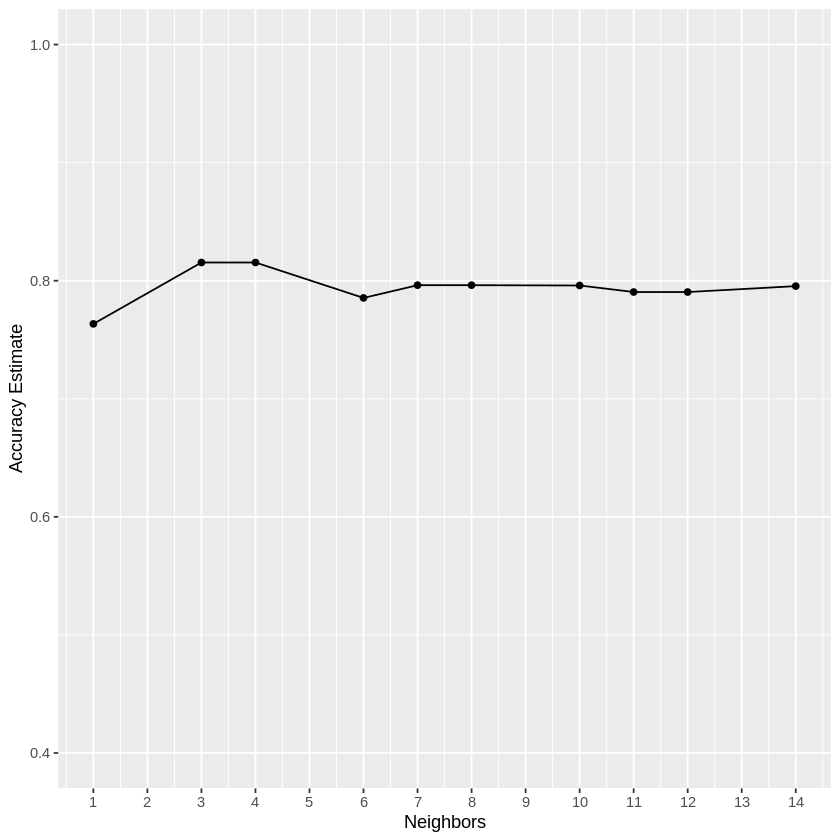

In [8]:
# Cross Validation
heart_vfold <- vfold_cv(heart_disease_training_plot_data, v = 5, strata = has_heart_disease)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_results <- workflow() |>
      add_recipe(heart_disease_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = heart_vfold, grid = 10) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

We see from the plot that the K value with the highest training accuracy is k = 3 so we select this as our value. We create our model specification with k = 3 and combine it with our recipe from before into a workflow and build our classifier.

In [9]:
knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_fit <- workflow() |>
      add_recipe(heart_disease_recipe) |>
      add_model(knn_model) |>
      fit(data = heart_disease_training_plot_data)

#heart_fit

Now, we test our classifier by making predictions for the data in our training set. We see the prediction accuracy is about 81.8% which is relatively good.

In [10]:
heart_test_predictions <- predict(heart_fit , heart_disease_data_testing) |>
      bind_cols(heart_disease_data_testing)
heart_test_predictions

heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = has_heart_disease, estimate = .pred_class)
heart_prediction_accuracy

.pred_class age sex chest_pain_type resting_blood_pressure cholestorol
1  No          29  1   2               120                    243        
2  No          31  0   2               100                    219        
3  No          32  1   2               110                    225        
⋮  ⋮           ⋮   ⋮   ⋮               ⋮                      ⋮          
64 Yes         47  1   4               160                    291        
65 Yes         52  1   4               140                    266        
66 Yes         58  0   2               180                    393        
   fasting_blood_sugar restecg max_heart_rate exercise_induced_angina oldpeak
1  0                   0       160            0                       0      
2  0                   1       150            0                       0      
3  0                   0       184            0                       0      
⋮  ⋮                   ⋮       ⋮              ⋮                       ⋮      
64 0                   1       158            1                       3      
65 0                   0       134            1                       2      
66 0                   0       110            1                       1      
   has_heart_disease
1  No               
2  No               
3  No               
⋮  ⋮                
64 Yes              
65 Yes              
66 Yes

.metric  .estimator .estimate
1 accuracy binary     0.8181818
2 kap      binary     0.6195965

Visualization below: NEEDS TO BE EDITED before final submission.

age       sex        chest_pain_type resting_blood_pressure cholestorol
1   -2.512196  0.5935911 -0.9731865      -0.1742372             -1.8547289 
2   -2.259682 -1.6760220 -2.0045527       2.1568947             -0.2021081 
3   -2.007167 -1.6760220 -0.9731865      -1.6311946             -0.8159386 
⋮   ⋮         ⋮          ⋮               ⋮                      ⋮          
193 0.7704933 -1.6760220 0.05817963      -0.1742372             0.6950289  
194 1.0230079  0.5935911 1.08954577       1.2827202             1.4505127  
195 2.1593235  0.5935911 1.08954577      -0.1742372             0.3959833  
    fasting_blood_sugar restecg    max_heart_rate exercise_induced_angina
1   -0.287934            3.8304213 1.879150       -0.6729706             
2   -0.287934            1.6591069 1.246858       -0.6729706             
3   -0.287934           -0.5122075 1.036094       -0.6729706             
⋮   ⋮                   ⋮          ⋮              ⋮                      
193 -0.287934            1.6591069 -1.7038373     1.478329               
194  3.455208           -0.5122075  0.4038021     1.478329               
195 -0.287934            1.6591069 -1.0715455     1.478329               
    oldpeak    has_heart_disease
1   -0.6464198 No               
2   -0.6464198 No               
3   -0.6464198 No               
⋮   ⋮          ⋮                
193 -0.6464198 Yes              
194  2.4918007 Yes              
195  0.3996537 Yes

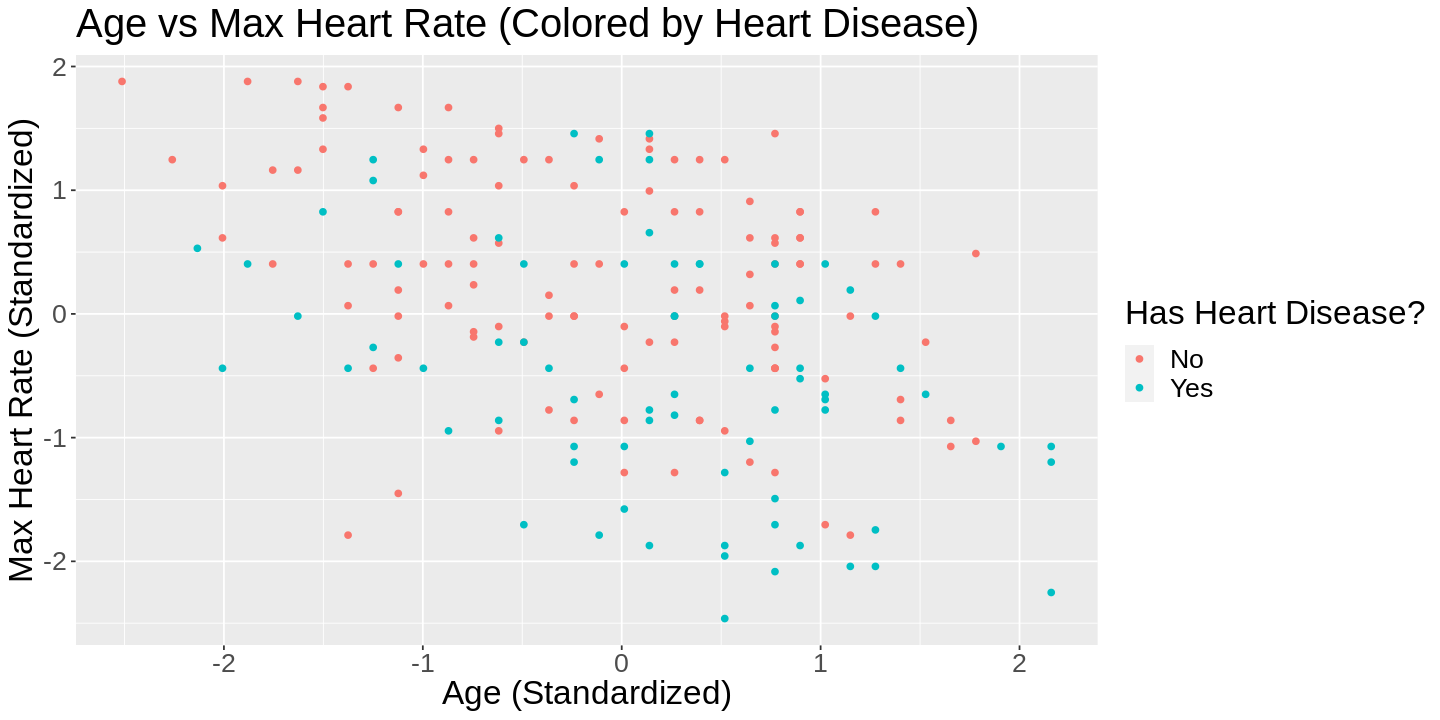

In [11]:
heart_disease_recipe <- heart_disease_recipe |>
   prep()
scaled_heart_disease_data <- bake(heart_disease_recipe, heart_disease_training_plot_data)

# Print scaled data
scaled_heart_disease_data

# Change plot dimensions
options(repr.plot.width = 12, repr.plot.height = 6)

# Plot data
heart_disease_plot <- scaled_heart_disease_data |>
   ggplot(aes(x = age, y = max_heart_rate, color = has_heart_disease)) +
   geom_point() +
   theme(text = element_text(size = 20)) +
   labs(x = "Age (Standardized)", y = "Max Heart Rate (Standardized)", title = "Age vs Max Heart Rate (Colored by Heart Disease)", color = "Has Heart Disease?")

# Display plot
heart_disease_plot

# Expected Outcomes and Significance

These findings could potentially show new relationships between factors that are known to be related to heart disease. This is impactful, because heart disease is a very common cause of death everywhere. It is important for data scientists in the healthcare industry to uncover as much information about heart disease.

A question this could lead to is whether or not our findings could be applied by heart doctors to help them predict heart disease more accurately.
Another question is whether or not certain predictors have more correlation to heart disease than others.